# SPAN autocorrelation analysis
Autocorrelation analysis based on model coverage scores

Please use `--ext` parameter to save scores.

In [2]:
# % matplotlib inline
# % config InlineBackend.figure_format='retina'
import glob
import os.path

import numpy as np
# Just load seaborn & set theme and the chart looks better:
import seaborn as sns
from bokeh.io import output_notebook, show
from bokeh.layouts import gridplot
from bokeh.plotting import figure

sns.set_theme()

output_notebook()

Loading BokehJS ...

In [3]:
FOLDER = os.path.expanduser('~/data/2022_GSE26320/span')
NAMES = ['GSM646316_GM12878_H3K27ac_rep1', 'GSM646320_GM12878_H3K36me3_rep1', 'GSM646326_GM12878_H3K4me3_rep1',
         'GSM646318_GM12878_H3K27me3_rep1', 'GSM646322_GM12878_H3K4me1_rep1']


In [5]:
coverages = {n: glob.glob(FOLDER + '/cache/*' + n + '*.npz')[0] for n in NAMES}
print('Coverages', coverages)
models = {}
for n in NAMES:
    for f in glob.glob(FOLDER + '/fit/*.span-nb3zhmm'):
        if '_200' in f and all(p in f for p in n.split('_')):
            models[n] = f
            break
print('Models', models)

Coverages {'GSM646316_GM12878_H3K27ac_rep1': '/home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646316_GM12878_H3K27ac_rep1_unique#ef96f.npz', 'GSM646320_GM12878_H3K36me3_rep1': '/home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646320_GM12878_H3K36me3_rep1_unique#92741.npz', 'GSM646326_GM12878_H3K4me3_rep1': '/home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646326_GM12878_H3K4me3_rep1_unique#ea708.npz', 'GSM646318_GM12878_H3K27me3_rep1': '/home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646318_GM12878_H3K27me3_rep1_unique#7109e.npz', 'GSM646322_GM12878_H3K4me1_rep1': '/home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646322_GM12878_H3K4me1_rep1_unique#f31f9.npz'}
Models {'GSM646316_GM12878_H3K27ac_rep1': '/home/jetbrains/data/2022_GSE26320/span/fit/GSM646316_GM12878_H3K27ac_rep1_200.span-nb3zhmm', 'GSM646320_GM12878_H3K36me3_rep1': '/home/jetbrains/data/2022_GSE26320/span/fit/GSM646320_GM12878_H3K36me3_rep1_200.span-nb3zhmm', 'GSM646326_GM1287

In [6]:
import tempfile
from scipy.stats import nbinom as nb
import os
from collections import Counter
import json


def plot_coverage(name, bin=200, n=20):
    model_path = models[name]
    print('Loading model', model_path)
    with tempfile.TemporaryDirectory() as tmp:
        ! tar -xf {model_path} --directory {tmp}
        with open(os.path.join(tmp, 'model.json')) as mi:
            model = json.load(mi)
        with open(os.path.join(tmp, 'information.json')) as fi:
            chrom_sizes = json.load(fi)['chromosomes_sizes']
    meanLow, fsLow = model['neg_bin_emission_schemes'][0]['mean'], model['neg_bin_emission_schemes'][0]['failures']
    meanHigh, fsHigh = model['neg_bin_emission_schemes'][1]['mean'], model['neg_bin_emission_schemes'][1]['failures']

    nbLow = nb(fsLow, fsLow / (meanLow + fsLow))
    # print('Low', meanLow, fsLow, nbLow.mean())

    nbHigh = nb(fsHigh, fsHigh / (meanHigh + fsHigh))
    # print('High', meanHigh, fsHigh, nbHigh.mean())
    # print('\n')

    coverage_path = coverages[name]
    print('Loading coverage', coverage_path)
    raw_coverage = np.load(coverage_path)
    coverage = Counter()
    for chr in chrom_sizes.keys():
        if f'{chr}/+' in raw_coverage:
            for p in raw_coverage[f'{chr}/+']:
                coverage[int(p / bin)] += 1
            for p in raw_coverage[f'{chr}/-']:
                coverage[int(p / bin)] += 1
    cvalues = coverage.values()
    print('Summary coverage', sum(cvalues))
    notnull = [x for x in cvalues if x > 0]
    print('Summary notnull bins', len(notnull))
    print('Max coverage', max(notnull))

    hist, edges = np.histogram([x for x in notnull if x <= n], density=True, bins=(n))
    xs = np.linspace(1, n, n)
    low = [nbLow.pmf(x) for x in xs]
    high = [nbHigh.pmf(x) for x in xs]

    p = figure(title=name + ' bin' + str(bin) + ' >0', tools='', background_fill_color="#fafafa")
    p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color="navy", line_color="white", alpha=0.5)

    p.line(xs, low, line_color="orange", line_width=5, alpha=0.7, legend_label="Low")
    p.line(xs, high, line_color="green", line_width=5, alpha=0.7, legend_label="High")

    # p.y_range.start = 0
    # p.y_range.end = 1
    # p.y_scale = LogScale()
    p.x_range.start = 1
    p.x_range.end = n
    p.xaxis.axis_label = 'x'
    p.yaxis.axis_label = 'Pr(x)'
    p.grid.grid_line_color = "white"

    return p


show(plot_coverage('GSM646320_GM12878_H3K36me3_rep1'))

Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646320_GM12878_H3K36me3_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646320_GM12878_H3K36me3_rep1_unique#92741.npz
Summary coverage 9686113
Summary notnull bins 1120364
Max coverage 190


In [7]:
show(gridplot([plot_coverage(n) for n in NAMES], ncols=1,
              width=500, height=300, toolbar_location=None))

Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646316_GM12878_H3K27ac_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646316_GM12878_H3K27ac_rep1_unique#ef96f.npz
Summary coverage 6773817
Summary notnull bins 964091
Max coverage 163
Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646320_GM12878_H3K36me3_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646320_GM12878_H3K36me3_rep1_unique#92741.npz
Summary coverage 9686113
Summary notnull bins 1120364
Max coverage 190
Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646326_GM12878_H3K4me3_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646326_GM12878_H3K4me3_rep1_unique#ea708.npz
Summary coverage 6328966
Summary notnull bins 1037152
Max coverage 160
Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646318_GM12878_H3K27me3_rep1_200.span-nb3zhmm
L

# Autocorrelation

In [8]:
from math import ceil
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

def get_binned_coverage(raw_coverage, chrom_sizes, bin):
    coverage = np.zeros(sum(int(ceil(v / bin)) for k, v in chrom_sizes.items()))
    offset = 0
    for chr in chrom_sizes.keys():
        for p in raw_coverage[f'{chr}/+']:
            coverage[offset + int(p / bin)] += 1
        for p in raw_coverage[f'{chr}/-']:
            coverage[offset + int(p / bin)] += 1
        offset += int(ceil(chrom_sizes[chr] / bin))
    return coverage

def autocorr_full(
        name,
        bin=200,
        min_dist=0,
        max_dist=20,
        ignore_zero=True,
        xticks=None,
        ylim=None,
):
    model_path = models[name]
    print('Loading model', model_path)
    with tempfile.TemporaryDirectory() as tmp:
        ! tar -xf {model_path} --directory {tmp}
        with open(os.path.join(tmp, 'information.json')) as fi:
            chrom_sizes = json.load(fi)['chromosomes_sizes']
    coverage_path = coverages[name]
    print('Loading coverage', coverage_path)
    raw_coverage = np.load(coverage_path)
    coverage = get_binned_coverage(raw_coverage, chrom_sizes, bin)
    if ignore_zero:
        coverage = coverage[coverage > 0]
    print('Total coverage size', len(coverage))
    print('Max coverage', max(coverage))

    print('Computing correlations')
    correlations = []
    for d in range(min_dist, max_dist):
        corr, pval = pearsonr(coverage, np.roll(coverage, d))
        correlations.append(corr)

    plt.plot(range(min_dist, max_dist), correlations)
    if ylim is not None:
        plt.ylim(ylim)
    if xticks is not None:
        plt.xticks(xticks)
    plt.xlabel("Distance")
    plt.ylabel("Correlation")
    plt.title(name)
    plt.show()

# autocorr_full('GSM646320_GM12878_H3K36me3_rep1')

Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646316_GM12878_H3K27ac_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646316_GM12878_H3K27ac_rep1_unique#ef96f.npz
Total coverage size 2770194
Max coverage 123.0
Computing correlations


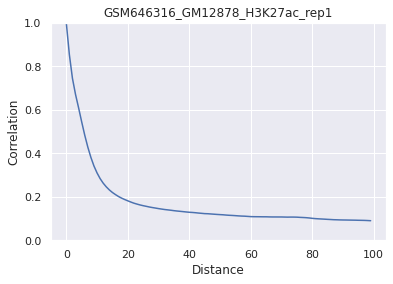

Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646316_GM12878_H3K27ac_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646316_GM12878_H3K27ac_rep1_unique#ef96f.npz
Total coverage size 2770194
Max coverage 123.0
Computing correlations


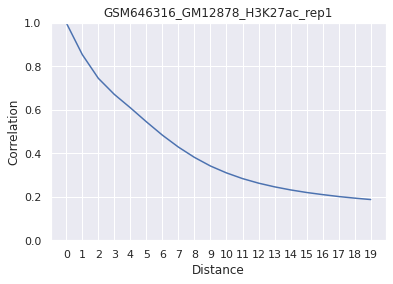

Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646320_GM12878_H3K36me3_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646320_GM12878_H3K36me3_rep1_unique#92741.npz
Total coverage size 5587295
Max coverage 181.0
Computing correlations


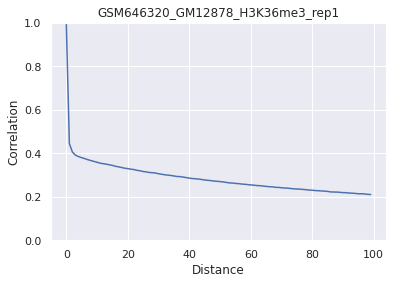

Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646320_GM12878_H3K36me3_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646320_GM12878_H3K36me3_rep1_unique#92741.npz
Total coverage size 5587295
Max coverage 181.0
Computing correlations


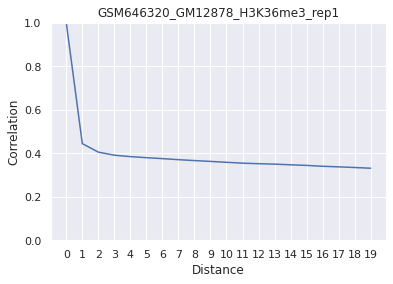

Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646326_GM12878_H3K4me3_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646326_GM12878_H3K4me3_rep1_unique#ea708.npz
Total coverage size 3733481
Max coverage 155.0
Computing correlations


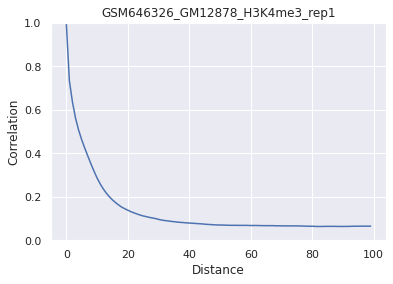

Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646326_GM12878_H3K4me3_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646326_GM12878_H3K4me3_rep1_unique#ea708.npz
Total coverage size 3733481
Max coverage 155.0
Computing correlations


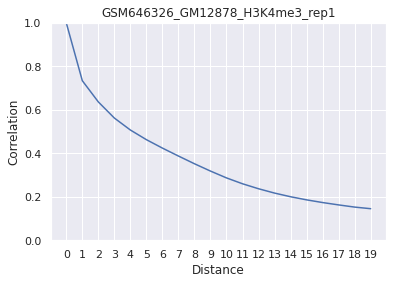

Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646318_GM12878_H3K27me3_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646318_GM12878_H3K27me3_rep1_unique#7109e.npz
Total coverage size 6081198
Max coverage 133.0
Computing correlations


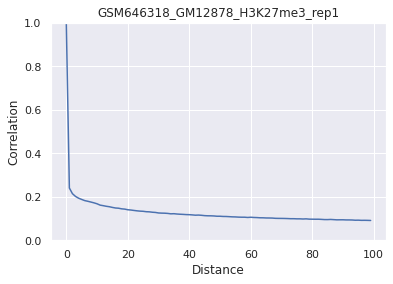

Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646318_GM12878_H3K27me3_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646318_GM12878_H3K27me3_rep1_unique#7109e.npz
Total coverage size 6081198
Max coverage 133.0
Computing correlations


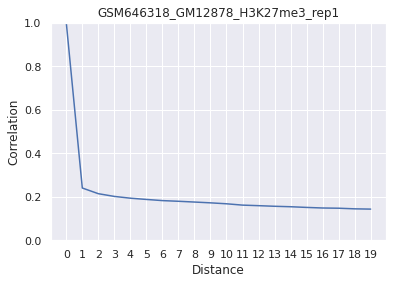

Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646322_GM12878_H3K4me1_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646322_GM12878_H3K4me1_rep1_unique#f31f9.npz
Total coverage size 3349293
Max coverage 107.0
Computing correlations


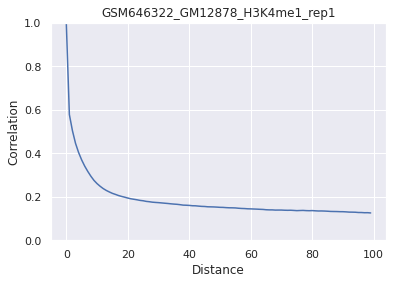

Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646322_GM12878_H3K4me1_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646322_GM12878_H3K4me1_rep1_unique#f31f9.npz
Total coverage size 3349293
Max coverage 107.0
Computing correlations


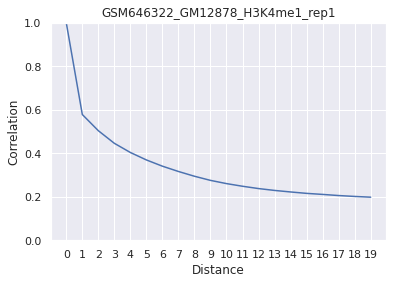

In [9]:
for n in NAMES:
    autocorr_full(n, ylim=(0, 1), max_dist=100)
    autocorr_full(n, ylim=(0, 1), max_dist=20, xticks=range(0, 20))

## Autocorrelation between peaks state

In [10]:
import itertools

def autocorr_peaks(
        name,
        bin=200,
        min_dist=0,
        max_dist=20,
        ignore_zero=True,
        xticks=None,
        ylim=None,
):
    model_path = models[name]
    print('Loading model', model_path)
    with tempfile.TemporaryDirectory() as tmp:
        ! tar -xf {model_path} --directory {tmp}
        with open(os.path.join(tmp, 'information.json')) as fi:
            chrom_sizes = json.load(fi)['chromosomes_sizes']
            # print(chrom_sizes)
        states = np.load(os.path.join(tmp, 'states.npz'))['state']

    coverage_path = coverages[name]
    print('Loading coverage', coverage_path)
    offset = 0
    chr_peaks = {}
    print('States len', len(states))
    # print('Per chr bins', sum(int(ceil(chr_size / bin)) for chr_size in chrom_sizes.values()))
    for chr, chr_size in chrom_sizes.items():
        chr_peaks[chr] = []
        bins = int(ceil(chr_size / bin))
        peak_start = None
        # print('Chromosome', chr, 'Offset', offset)
        for i in range(bins):
            if states[offset + i] == b'H':
                if peak_start is None:
                    peak_start = i
            else:
                if peak_start is not None:
                    chr_peaks[chr].append((offset + peak_start, offset + i))
                    peak_start = None
        if peak_start is not None:
            chr_peaks[chr].append((offset + peak_start, offset + bins))
        offset += bins

    h_peaks = len(list(itertools.chain(*chr_peaks.values())))
    print('Total model H states', h_peaks)
    h_len = sum(e - s for (s, e) in list(itertools.chain(*chr_peaks.values())))
    print('Total model H states length', h_len)

    coverage_path = coverages[name]
    print('Loading coverage', coverage_path)
    raw_coverage = np.load(coverage_path)
    coverage = get_binned_coverage(raw_coverage, chrom_sizes, bin)

    print('Computing correlations')
    correlations = []
    for d in range(min_dist, max_dist):
        c1 = np.zeros(max_dist * (h_peaks + 1) + h_len)
        c2 = np.zeros(len(c1))
        for i, (s, e) in enumerate(itertools.chain(*chr_peaks.values())):
            for x in range(e - s - d):
                c1[(i + 1) * max_dist + x] = coverage[s + x]
                c2[(i + 1) * max_dist + x] = coverage[s + x + d]
        corr, pval = pearsonr(c1, c2)
        correlations.append(corr)

    plt.plot(range(min_dist, max_dist), correlations)
    if ylim is not None:
        plt.ylim(ylim)
    if xticks is not None:
        plt.xticks(xticks)
    plt.xlabel("Distance")
    plt.ylabel("Correlation")
    plt.title(name)
    plt.show()


# autocorr_peaks('GSM646320_GM12878_H3K36me3_rep1')

Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646316_GM12878_H3K27ac_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646316_GM12878_H3K27ac_rep1_unique#ef96f.npz
States len 15921463
Total model H states 21089
Total model H states length 229570
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646316_GM12878_H3K27ac_rep1_unique#ef96f.npz
Computing correlations


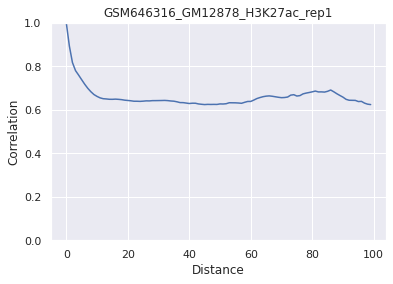

Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646316_GM12878_H3K27ac_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646316_GM12878_H3K27ac_rep1_unique#ef96f.npz
States len 15921463
Total model H states 21089
Total model H states length 229570
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646316_GM12878_H3K27ac_rep1_unique#ef96f.npz
Computing correlations


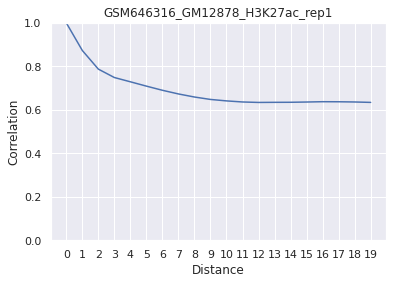

Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646320_GM12878_H3K36me3_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646320_GM12878_H3K36me3_rep1_unique#92741.npz
States len 15954759
Total model H states 32009
Total model H states length 661524
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646320_GM12878_H3K36me3_rep1_unique#92741.npz
Computing correlations


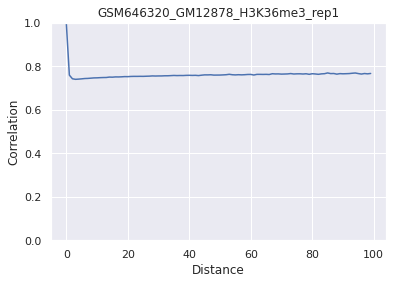

Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646320_GM12878_H3K36me3_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646320_GM12878_H3K36me3_rep1_unique#92741.npz
States len 15954759
Total model H states 32009
Total model H states length 661524
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646320_GM12878_H3K36me3_rep1_unique#92741.npz
Computing correlations


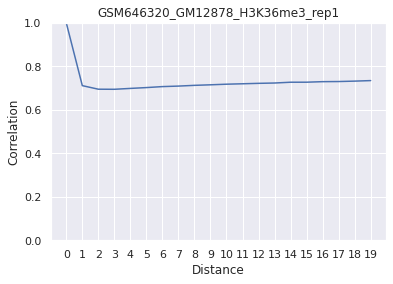

Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646326_GM12878_H3K4me3_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646326_GM12878_H3K4me3_rep1_unique#ea708.npz
States len 15943075
Total model H states 17798
Total model H states length 214745
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646326_GM12878_H3K4me3_rep1_unique#ea708.npz
Computing correlations


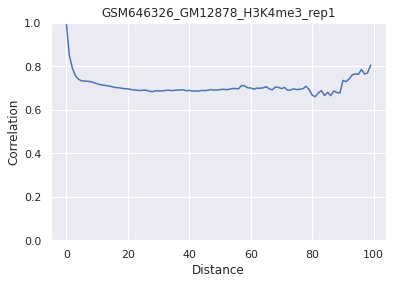

Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646326_GM12878_H3K4me3_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646326_GM12878_H3K4me3_rep1_unique#ea708.npz
States len 15943075
Total model H states 17798
Total model H states length 214745
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646326_GM12878_H3K4me3_rep1_unique#ea708.npz
Computing correlations


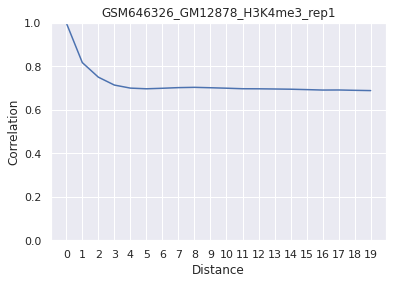

Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646318_GM12878_H3K27me3_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646318_GM12878_H3K27me3_rep1_unique#7109e.npz
States len 15956058
Total model H states 22111
Total model H states length 6991598
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646318_GM12878_H3K27me3_rep1_unique#7109e.npz
Computing correlations


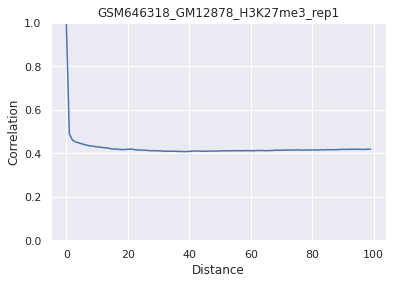

Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646318_GM12878_H3K27me3_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646318_GM12878_H3K27me3_rep1_unique#7109e.npz
States len 15956058
Total model H states 22111
Total model H states length 6991598
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646318_GM12878_H3K27me3_rep1_unique#7109e.npz
Computing correlations


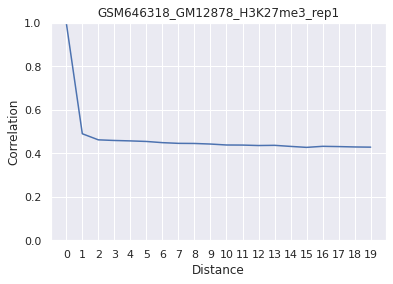

Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646322_GM12878_H3K4me1_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646322_GM12878_H3K4me1_rep1_unique#f31f9.npz
States len 15938381
Total model H states 35253
Total model H states length 405224
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646322_GM12878_H3K4me1_rep1_unique#f31f9.npz
Computing correlations


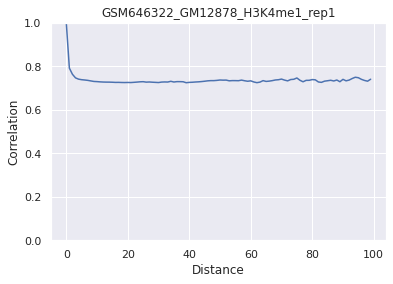

Loading model /home/jetbrains/data/2022_GSE26320/span/fit/GSM646322_GM12878_H3K4me1_rep1_200.span-nb3zhmm
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646322_GM12878_H3K4me1_rep1_unique#f31f9.npz
States len 15938381
Total model H states 35253
Total model H states length 405224
Loading coverage /home/jetbrains/data/2022_GSE26320/span/cache/coverage_GSM646322_GM12878_H3K4me1_rep1_unique#f31f9.npz
Computing correlations


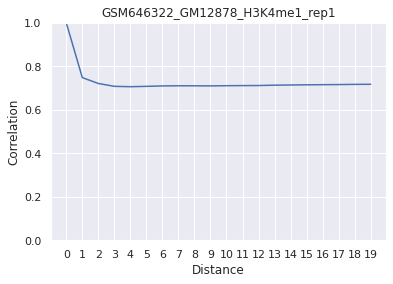

In [11]:
for n in NAMES:
    autocorr_peaks(n, ylim=(0, 1), max_dist=100)
    autocorr_peaks(n, ylim=(0, 1), max_dist=20, xticks=range(0, 20))

In [12]:
# Test how additional 0 in vector affects correlation
a = [1, 2, 3]
b = [-2, 3, -4]
print(pearsonr(a, b)[0])
print(pearsonr(a + [0] * 100, b + [0] * 100)[0])

-0.2773500981126145
-0.39389460703566914
